<font color = gray>TITLE</font><br>
**Grade of Manufactured Alloy**<br><br>

<font color = gray>DESCRIPTION</font>

This dataset contains factors associated with the manufacture of a metal alloy.  The purpose of this analysis is to create a model predicting alloy grade based on the factors.

<font color = gray>COMMENTS</font><br>
\- `checked`at the end of a code block means the output was verified<br>
\- I'm assuming that each data row applies to a single processing batch

In [ ]:
#NOTES FROM KAGGLE

#This Python 3 environment comes with many helpful analytics libraries installed
#it is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
#For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
#You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<font color = gray>NOTES FROM THE CREATOR OF THE DATASET </font><br>

Manufacturing of any alloy is not a simple process. Many complicated factors are involved in the making of a perfect alloy, from the temperature at which various metals are melted to the presence of impurities to the cooling temperature set to cool down the alloy. Very minor changes in any of these factors can affect the quality or grade of the alloy produced.


Given are 28 distinguishing factors in the manufacturing of an alloy, the objective is to build a Machine Learning model that can predict the grade of the product using these factors.

You are provided with 28 anonymized factors (f0 to f27) that influence the making of a perfect alloy that is to be used for various applications based on the grade/quality of the obtained product.

In [ ]:
#READ INTO PANDAS TRAINING AND TEST DATASET, PRINT SHAPE, GET TRAIN INFO

df_test = pd.read_csv("/kaggle/input/metal-furnace-dataset/Test.csv")
df_train = pd.read_csv("/kaggle/input/metal-furnace-dataset/Train.csv")
pd.set_option('display.float_format', lambda x: '%.3e' % x)

print("train shape:",df_train.shape, "test shape:", df_test.shape)
df_train.describe()

## Exploratory Data Analysis

Information from Column view of the train dataset in Kaggle<br>
Note: 'rs' means distribution is right-skewed, 'ls' left - skewed

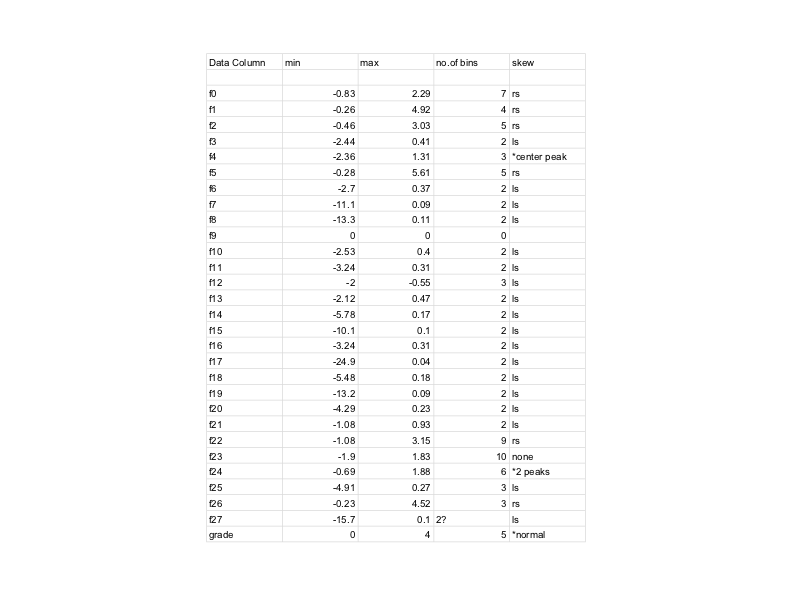<br>
<font color= yellow>OBSERVATIONS</font><br>
\- f9 not at all useful for modeling<br>
\- data has been converted to t or z scores (mean 0, std dev 1)<br>
\-Data leakage?  Do not know whether the train and test datasets were independently converted to t or z scores<br>
\- Appears most of the columns consists of data clustered near the mean with a few outliers (except f0,f22,f23,f24).<br>
\- Grade is categorical (only possible values are integers from 0 - 4)

In [ ]:
#list of feature column names (will be useful later)
x_params = df_test.columns.to_list()
x_params.remove('f9')
#checked

In [ ]:
# plot out the number of unique values in each column
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'ticks')

unique_values = {}
for x in x_params:
    unique_values[x] = df_train[x].value_counts().size

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
height = unique_values.values()
x = np.arange(len(x_params))
y = range(0,80,5)
plt.bar(x = x, height = height)
tick_positions = range(0,len(unique_values))
ax.set_xticks(tick_positions)
ax.set_xticklabels(unique_values.keys(), rotation =90, size = 12)
ax.set_xlabel("Parameter", c = 'y', size = 18)
ax.set_yticks(y)
ax.set_yticklabels(y)
ax.tick_params(axis = 'both',colors = 'black')
ax.grid(axis = 'y')
ax.set_ylabel("# of Unique Values", c = 'y', size = 18)
plt.show()


<font color = gray> OBSERVATIONS</font><br><br>
\- Parameters f22 - f24 have over 10 unique values<br>
\- Parameters f0 - f2, f5 have 5 to 10 unique values<br>
\- All other parameters (21 total) have < 5 unique values.<br>

f0 - f27 a mixture of continous and numeric categorical variables.

<font color = gray>THOUGHTS</font><br>
1. The factors are all numeric and (I assume) on an interval scale
2. This is a manufacturing problem, where knowing the effect of each factor on the output can lead to improved output.
3. Given 1. and 2. a regression, with weights for each factor, comes first to my mind.
    - Will the variables with few unique values consume degrees of freedom and add little predictive power to a regression because they are effectively binned? StatStack Exchange indicates such (https://stats.stackexchange.com/questions/311954/should-i-convert-integer-variables-with-very-few-unique-values-to-factors-for-pr?rq=1).  But, with the large number of data points relative to the number of factors will the loss of DofF matter?  I don't think it will.
    - Don't know whether the x relationships with y are linear or non-linear.
    - Don't know (yet) if multicollinearity exists.
2.  The y output has only 5 possible values.  A classification model may be more appropriate. 
    - No coefficients (weights) for each x variable (feature).
    - Many of the x variables appear categorical (not continuous). May not need coefficient weights (I'm thinking these categorical x values can't be modified {incoming raw material properties, for example}, therefore the weights for these x's have no practical value).<br>
    
<font color = gray>CONCLUSION:</font><br>

- Start with a Linear Regression (LR) model.  
    - Evaluate multicollinearity among the x variables.
    - Determine x variable correlation with grade.
    - Eliminate variables with correlations < abs(0.2) (This value is a judgement call).
    - Fit model to training data. 
    - Bin grade predictions.  
    - Determine accuracy of grade predictions.  
- Stop and rethink.

### Linear Regression - Multicollinearity ###

In [ ]:
#identify multicollinearity between independent variables with VIF
from sklearn.linear_model import LinearRegression
def vif (x_names, data):
    '''Use this function to determine the Variance Inflation Factor (VIF)for the x variables.
    VIF is a measure of multicollinearity between variables, and is 1/(1 - r2), where r2 is 
    is r squared between an x as the dependent variable and all the remaining x as independent
    variables'''
    vif_dict = {}
    for name in x_names:
        not_x = [i for i in x_names if i != name]
        X,y = data[not_x], data[name]
        #get r-squared
        r_squared= LinearRegression().fit(X,y).score(X,y)
        #get VIF
        vif = 1/(1 - r_squared)
        #write to dict
        vif_dict[name] = vif
    #vif's to dataframe
    return vif_dict
    
        

In [ ]:
x_vifs = vif(x_params, df_train)
print(x_vifs)

<font color = yellow>gray </font>
<br><br>
Potential multicolliearity between f3 and the other x variables (Literature says VIF < 5 not a concern; 5 < VIF < 10 possible concern; VIF > 10 is a concern.<br>

For now, I'm going to disregard potential multicollinearity.

### Initial Linear Regression - x Parameter Evaluation (Feature Selection) ###

In [ ]:
#correlations between x variables and grade w/0.2 as a cutoff (judgement call)

train_corr = df_train[x_params].corrwith(df_train['grade'])
sorted_corrs = abs(train_corr).sort_values()
strong_corrs = sorted_corrs[sorted_corrs > .2]
print("x variable coefficients for LR model",'\n',strong_corrs)

### Initial Linear Regression -  Model Fit and Prediction###

In [ ]:
#function for binning predictions

def binning (predictions):
    for n,p in enumerate(predictions):
        
        if p <= 0.5:
            predictions[n] = 0
        if (p > 0.5) and (p <= 1.5):
            predictions[n] = 1
        if (p > 1.5) and (p <= 2.5):
            predictions[n] = 2
        if (p > 2.5) and (p <= 3.5):
            predictions[n] = 3
        if p > 3.5:
            predictions[n] = 4
    
    return predictions

In [ ]:
# fit model with strongly correlated x's to training data

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = df_train[strong_corrs.index]
y = df_train['grade']
lr.fit(X,y)
train_pred = lr.predict(X)
train_pred_bin = binning(train_pred)

In [ ]:
#fraction of LR model grade predictions that were correct

from sklearn.metrics import accuracy_score

acc_perc = accuracy_score(df_train['grade'], train_pred_bin, normalize=True)
print('1st LR model accuracy: {:.2f}%'.format(acc_perc * 100))

## **Stop & Rethink** ###

<font color = gray>THOUGHTS</font><br>

- Basic LR using  features correlated (Pearson) with 'grade' having a corr coefficent > 0.2, and binning the predictions gave a training dataset accuracy of 77% 
    - Is this beneficial to the client company?  Can they implement process improvement with this information
- The predictive power of the model with new data may improve through regularization (penalize the model for having too many factors). Elastic Net CV (ENCV) combines Ridge and LASSO regression regularization to look for x variables having the greatest impact on `grade`.  ENCV is a structured way to reduce the number of factors through the regularization penalties l1 and l2. Per scikit- learn, try  l1/l2 ratios of  [.1, .5, .7, .9, .95, .99, 1].

### ENCV Regression -  Model Fit and Prediction###

In [ ]:
# fit Elastic Net model to training data using different l1/l2 ratios.
#The ElasticNetCV algorithm will choose the best fitting  ratio from the list

from sklearn.linear_model import ElasticNetCV
l1 = [.1, .5, .7, .9, .95, .99, 1] #list of l1/l2 ratios
X = df_train[x_params]
y = df_train['grade']

lren = ElasticNetCV(l1_ratio = l1)
lren.fit(X, y)
lren_predict = lren.predict(X)
bin_lren_predict = binning(lren_predict)
acc_lren = accuracy_score(y,bin_lren_predict, normalize = True)
print('alpha_value: {:.2f}'.format(lren.alpha_))
print('l1_ratio:', lren.l1_ratio_)
print('accuracy score using all non zero ENCV coefficients: {:.1f}%'
       .format(acc_lren * 100))


### ENCV Regression - Feature Evaluation###

In [ ]:
#identify ENCV coefficents by feature name
ENet_coeffs = {}
for i in range(0,len(x_params)-1):
    ENet_coeffs[x_params[i]] = round(lren.coef_[i],3)
    
ENet_coeffs

In [ ]:
#number of non zero ENCV x coefficients

non0_ENCV = []
for k,v in ENet_coeffs.items():
    if v != 0:
        non0_ENCV.append(k)
        
print('# of non-zero ENCV coefficients:', len(non0_ENCV))

<font color = gray>THOUGHTS</font><br>

- The ENCV model had 23 non-zero coefficients
- sorted Elastic Net cross validation (ENCV) feature coefficients (absolute value, high to low): f2, f18, f14, f5, f22, f6, f25, f17, etc.  f3, f4,f12 are 0.
- sorted correlation coefficients (feature with correlated with grade, high to low): f2, f3, f18, f14, f5, f6, f0, f4.
- f3 has a high correlation coefficient but the ENCV feature coefficient is 0 and VIF was ~5. 
- f2, f18, f14 feature coefficents are >2x the magnitude of the next largest coefficient.
- Revise original linear model with just f2, f18 and f14.

### Revised Linear Regression (3 Parameters) -  Model Fit and Prediction###

In [ ]:
#linear regression model, rev.1

lr_r1 = LinearRegression()
Xr1 = df_train[['f2','f14','f18']]
lr_r1.fit(Xr1,y)
lr_r1_pred = lr_r1.predict(Xr1)
bin_lr_r1_pred = binning(lr_r1_pred)
acc_lr_r1 = accuracy_score(df_train['grade'], bin_lr_r1_pred, normalize=True)
print('2nd LR model accuracy: {:.2f}%'.format(acc_lr_r1 * 100))

<font color = gray>LR SUMMARY</font>
<br><br>
3 models so far:<br>
- Linear Regression with x variables having a Pearson correlation with grade greater than 0.2
    - Training dataset prediction accuracy after binning: **<font color = red>77.42%**</font>
- ENCV Regression
    - Training dataset prediction accuracy after binning: **<font color = red>79.19%**</font>
- Linear Regression with three most significant x variables determined by ENCV
    - Training dataset prediction accuracy after binning: **<font color = red>76.94%</font>**

### Test Data Model Fit and Prediction###

In [ ]:
df_test.columns

<font color= gray>THOUGHT</font>

Oops...I should have picked up earlier that the test dataset didn't have the `grade` column.  Was hoping to use the test data set to evaluate accuracy of each model's predictions of grade.  I could take a portion of the train data set and set it aside for validating the model, but there would be data leakage between the smaller training data set and the validation set.<br>

I'll just name the predictions using each model and write to a csv.

In [ ]:
#Fit test data to all 3 LR models

X_test0 = df_test[strong_corrs.index]
test_pred0 = lr.predict(X_test0)
test_pred0_bin = binning(test_pred0) #predict using original LR model

X_testlren = df_test[x_params]
test_lren = lren.predict(X_testlren)
test_lren_bin = binning(test_lren) #predict using ENCV model

X_test1= df_test[['f2','f14','f18']]
test_pred1 = lr_r1.predict(X_test1)
test_pred1_bin = binning(test_pred1) #predict using revised LR model

print("""binned prediction for Original LR model named 'test_pred0_bin'""")
print("""binned prediction for ENCV model named 'test_lren_bin'""")
print("""binned prediction for LR model rev 1 named 'test_pred1_bin'""")

In [ ]:
#Write df_ test predicted values from the 3 regression predictions to csv files

#original lr model
np.savetxt("lr0_test_pred.csv", test_pred0_bin, delimiter=",")
#ENCV model
np.savetxt("lren_test_pred.csv", test_lren_bin, delimiter=",")
#revised lr model
np.savetxt("lr1_test_pred.csv", test_pred1_bin, delimiter=",")

As stated earlier, with so many variables in this dataset being categorical a classification model may be useful to this client company

## Random Forest Classification - Feature Selection ##

In [ ]:
from sklearn.feature_selection import RFECV  
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#function to select features from RFECV (Recursive Feature Elimination Cross Validation).  
#RFECV takes a model (in this case Random Forest) and recursively eliminates features until
# the maximum average model accuracy score from Cross Validation is achieved.

def feature_selection(df):
    all_X = x_params
    all_y = df['grade']
    rfc = RandomForestClassifier(n_estimators = 100, random_state = 1)
    grid = RFECV(rfc, cv = 5) #use the default no. of crossfolds
    grid.fit(X = df[all_X], y = all_y)
    num_features = grid.n_features_
    rank = grid.ranking_
    best_columns = df[all_X].columns[grid.support_]
    return all_X, all_y, num_features, rank, best_columns

In [ ]:
all_X, all_y,num_features,rank, best_columns = feature_selection(df_train)
print('# of cols chosen recursively from RF classifier:', num_features, '\n', 
      'column ranking:', rank, '\n','column names for model:',best_columns)

## Random Forest Classification - Model Fit and Predict ##

In [ ]:
#fit RF classifier using the selected features, make `grade` predictions, determine
#accuracy score

def my_RFC(df,Xcols,ycol):
    rfc = RandomForestClassifier(n_estimators = 100, random_state = 1)
    X = df[Xcols]
    y =df[ycol]
    rfc.fit(X,y)
    rfc_prediction = rfc.predict(X)
    rfc_acc = rfc.score(X,y)
    return rfc_prediction, rfc_acc

In [ ]:
rfc_prediction, rfc_acc = my_RFC(df_train, best_columns, 'grade')
print('Original RFC model accuracy: {:.2f}%'.format(rfc_acc * 100))

In [ ]:
#99+% accuracy. Check difference of actual grades - predicted grades.

grade_list = list(df_train['grade'])
diff = grade_list - rfc_prediction
rfc_check_df = pd.DataFrame(data = {'Grade_act': grade_list,
                                    'Grade_pred': rfc_prediction,
                                   'Diff': diff})
rfc_check_df['Diff'].value_counts()

In [ ]:
#Are the RFClassifier variables mostly categorical?
RFC_params_count = {}
for c in best_columns:
    RFC_params_count[c] = len(df_train[c].value_counts())
    
RFC_params_count
    

<font color = gray>THOUGHTS</font>

- 7 input variables (f4,f6,f10,f14,f15,f16,f18) are categorical.
- 3 input variables (f0,f2,f5) are "almost" categorical.
- 3 input variables (f22, f23,f24) are continuous.
- Rerun the RFClassifier with the categorical variables, check accuracy


## Random Forest Classification - Feature Modification ##

In [ ]:
X_cat = []
for k,v in RFC_params_count.items():
    if v <= 3:
        X_cat.append(k)
        
X_cat

In [ ]:
#7 categorical variable RFC model accuracy
rfc_prediction1, rfc_acc1 = my_RFC(df_train, X_cat, 'grade')
print('7 categorical parameter RFC model accuracy: {:.2f}%'.format(rfc_acc1 * 100))


In [ ]:
#Add the 3 "almost"categorical variables to the 7 categorical
Xcat_10 = X_cat.copy()
Xcat_10.extend(['f0','f2','f5'])
Xcat_10

In [ ]:
#rerun my_RFC with 10 variables
rfc_prediction2,rfc_acc2 = my_RFC(df_train, Xcat_10, 'grade')
print('''10 "categorical" parameter RFC model accuracy: {:.2f}%'''.format(rfc_acc2 * 100))

<font color = gray>SUMMARY</font>

- 7 categorical variable RFC prediction accuracy of train data: <font color= red>83%</font>.
    - Is this useful to the people making the alloy?  Can these variable be used to predict grade before starting to make the alloy?
- 7 categorical + 3 'almost' categorical variable RFC prediction accuracy of train data: <font color= red>91%</font>.
    - Can these 3 additional variables be used to predict grade prior to making the alloy?
- 7 categorical + 3 'almost' categorical  + 3 continuous variable prediction accuracy: <font color= red>99+%</font>
    - I assume these continuous variables are machine actuals (averaged over the time of alloy manufacture?) 

<font color = gray>THOUGHTS</font>

- I hypothesize binning the 3 continous variables and creating a 4th RFC model would lead to a prediction accuracy between 91% and 99%.  This would allow those making the alloy to create a table of settings for the 13 variables and predicted grade.  Or, "clustering" could be done based on the 13 variable model predictions.  For a single grade,cluster the data rows where values for the 10 categorical variables are equal, and determine the range of the continous variables witin that cluster.

- I'm going to stop here and make this notebook available to the owner of the dataset.  I'll write a final code block where the 3 RFC model predictions are written to .csv files.

In [ ]:
#Write df_test predicted values from the 3 classificationpredictions to csv files

##13 parameter model
np.savetxt("rfc0_test_pred.csv", rfc_prediction, delimiter=",") 
##10 parameter model
np.savetxt("rfc1_test_pred.csv", rfc_prediction1, delimiter=",")
#7 parameter model
np.savetxt("rfc2_test_pred.csv", rfc_prediction2, delimiter=",")